## Simplifying Graph Convolutional Networks


**Abstract**
* Graph Convolutional Networks (GCNs) and their variants have experienced significant attention and have become the de facto methods for learning graph representations. GCNs derive inspiration primarily from recent deep learning approaches, and as a result, may inherit unnecessary complex- ity and redundant computation. In this paper, we reduce this excess complexity through suc- cessively removing nonlinearities and collapsing weight matrices between consecutive layers. We theoretically analyze the resulting linear model and show that it corresponds to a fixed low-pass filter followed by a linear classifier. Notably, our experimental evaluation demonstrates that these simplifications do not negatively impact accuracy in many downstream applications. Moreover, the resulting model scales to larger datasets, is natu- rally interpretable, and yields up to two orders of magnitude speedup over FastGCN.


Paper: implementation [Wu et al. (2019)](https://proceedings.mlr.press/v97/wu19e.html) as one of the datasets of the `Planetoid` benchmark suite.
 

In [22]:
# libraries

import os.path as osp
import sys
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SGConv
import torch.nn.functional as F 


## Import dataset

In [23]:
# ===================Import dataset==============

dataset = 'Cora'
#path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', dataset)
#dataset = Planetoid(path, dataset)
dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]
print("Cora: ", data)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Cora:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


## Contruct The Simplifying Graph Covn Network Model

In [24]:
# =================== Contruct The Simplifying Graph Covn Network Model==============
SGC_model = SGConv(in_channels= data.num_features, # Number of features
                    out_channels = dataset.num_classes, # Dimension of embedding
                    K = 1,
                    cached = True
                    )
# =================== GET Embedding ==================
print("Shape of the original data: ", data.x.shape)
print("Shape of the embedding data: ", SGC_model(data.x, data.edge_index).shape)

Shape of the original data:  torch.Size([2708, 1433])
Shape of the embedding data:  torch.Size([2708, 7])


## Contruct the NODE Classification Model

In [25]:
#==================== Contruct the NODE Classification Model ==================
class SGCNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SGConv(in_channels = dataset.num_features, # Number of features
                            out_channels = dataset.num_classes, # dimension of embedding
                            K =2, cached = True)
    def forward(self):
        x = self.conv1(data.x, data.edge_index) # applying convolution to data
        return F.log_softmax(x, dim =1)
        

In [26]:
# device consideration
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SGC_model, data = SGCNet().to(device), data.to(device)
optimizer = torch.optim.Adam(SGC_model.parameters(), lr=0.2,weight_decay=0.005)

In [27]:
# learning parameters
for i, parameters in SGC_model.named_parameters():
    print(" Parameters {}".format(i))
    print(" Shape: ", parameters.shape)

 Parameters conv1.lin.weight
 Shape:  torch.Size([7, 1433])
 Parameters conv1.lin.bias
 Shape:  torch.Size([7])


## Train model

In [28]:
# ============ TRAIN ==================
train_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
def train():
    SGC_model.train()
    optimizer.zero_grad()
    predicted_y = SGC_model()
    true_y = data.y
    losses = F.nll_loss(predicted_y[data.train_mask], true_y[data.train_mask])
    losses.backward()
    optimizer.step()
    train_losses.append(losses.item())  # Store the loss value


## TEst function

In [29]:
# =================TEST Function ====================
@torch.no_grad()
def test():
    SGC_model.eval()   # set the model.training to be false
    logits, accs = SGC_model(), [] # log probability and accuracy llist of model
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs



## Training our model


In [30]:
#===================== Putting all together ================
best_val_acc = 0
test_acc = 0
for epoch in range(1, 101):
    train()
    train_acc, val_acc, tmp_test_acc = test()

    # Append accuracies to lists
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(tmp_test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc

    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, train_losses[-1], train_acc, best_val_acc, test_acc))

Epoch: 001, Loss: 1.9491, Train: 0.9643, val: 0.6620, Test: 0.6810
Epoch: 002, Loss: 0.4647, Train: 0.9786, val: 0.7780, Test: 0.7950
Epoch: 003, Loss: 0.2465, Train: 1.0000, val: 0.7780, Test: 0.7950
Epoch: 004, Loss: 0.1854, Train: 1.0000, val: 0.7780, Test: 0.7950
Epoch: 005, Loss: 0.1938, Train: 1.0000, val: 0.7780, Test: 0.7950
Epoch: 006, Loss: 0.2314, Train: 1.0000, val: 0.7780, Test: 0.7950
Epoch: 007, Loss: 0.2733, Train: 1.0000, val: 0.7780, Test: 0.7950
Epoch: 008, Loss: 0.3211, Train: 1.0000, val: 0.7800, Test: 0.8020
Epoch: 009, Loss: 0.3435, Train: 0.9929, val: 0.7800, Test: 0.8020
Epoch: 010, Loss: 0.3468, Train: 0.9929, val: 0.7800, Test: 0.8020
Epoch: 011, Loss: 0.3329, Train: 0.9929, val: 0.7800, Test: 0.8020
Epoch: 012, Loss: 0.3108, Train: 0.9929, val: 0.7800, Test: 0.8020
Epoch: 013, Loss: 0.2952, Train: 1.0000, val: 0.7800, Test: 0.8020
Epoch: 014, Loss: 0.2863, Train: 1.0000, val: 0.7800, Test: 0.8020
Epoch: 015, Loss: 0.2836, Train: 1.0000, val: 0.7880, Test: 0.

## Ploting loss and accuracy

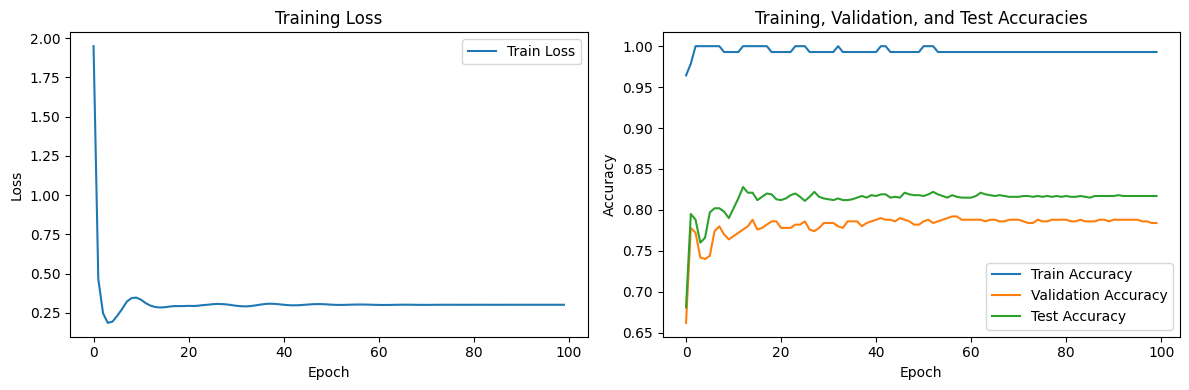

In [34]:

#===================== Ploting loss and accuracy ==========
def plot_loss_and_accuracy():
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation, and Test Accuracies')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_loss_and_accuracy()